# Mushroom Encoded Dataset: Multiple BART Chains Analysis

This notebook compares Random Forest Regressor, DefaultBART, and LogisticBART with varying numbers of chains while keeping total iterations fixed at 480.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score
from sklearn.calibration import calibration_curve
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OrdinalEncoder, normalize
from bart_playground import *
from bart_playground.bart import DefaultBART, LogisticBART

In [2]:
# Parameters
N_TREES = 100
TOTAL_BUDGET = 210  # Keep (n_post + n_skip) * bart_num
RATIO_TARGET = 0.2  # Target ratio of n_post/n_skip
RANDOM_STATE = 0
PROPOSAL_PROBS = {"grow": 0.4, "prune": 0.4, "change": 0.1, "swap": 0.1}

np.random.seed(RANDOM_STATE)

In [3]:
def load_mushroom():
    X, y = fetch_openml('mushroom', version=1, return_X_y=True)
    for col in X.select_dtypes('category'):
        # -1 in codes indicates NaN by pandas convention
        X[col] = X[col].cat.codes
    X = normalize(X)
    y_array = y.to_numpy().reshape(-1, 1)
    y_arm = OrdinalEncoder(dtype=int).fit_transform(y_array).flatten()
    
    # make the dataset a little bit smaller
    indices = np.random.choice(X.shape[0], size=2000, replace=False)
    X = X[indices, :]
    y_arm = y_arm[indices]
    
    return X, y_arm

def load_mushroom_encoded():
    X, y_arm = load_mushroom()
    
    n_arm = np.max(y_arm) + 1
    dim = X.shape[1] * n_arm # total number of encoded covariates (location-encoded for each arm) 
    act_dim = X.shape[1] # number of covariates
    covariates = np.zeros((X.shape[0], dim))
    rewards = np.zeros((X.shape[0], ))
    for cursor in range(X.shape[0]):
        a = np.random.randint(0, n_arm)
        covariates[cursor, a * act_dim:(a * act_dim + act_dim)] = X[cursor]
        if y_arm[cursor] == a:
            rewards[cursor] = 1 # reward is 1 if the true category matches the chosen arm

    return covariates, rewards

In [4]:
def mce_score(prob_true, prob_pred):
    """Maximum Calibration Error"""
    diffs = np.abs(prob_true - prob_pred)
    return np.max(diffs)

def evaluate_single_model(model, model_name, X_train, X_test, y_train, y_test):
    """Evaluate a single model and return metrics"""
    
    if model_name == "RandomForestRegressor":
        # Regression method treating 0/1 as continuous
        model.fit(X_train, y_train)
        raw_pred = model.predict(X_test)
        y_pred_prob = np.clip(raw_pred, 1e-9, 1 - 1e-9)
        y_pred = (y_pred_prob > 0.5).astype(int)
        
    elif "LogisticBART" in model_name:
        # Binary BART classifier
        model.fit(X_train, y_train)
        proba_output = model.predict_proba(X_test)
        y_pred_prob = proba_output[:, 1]
        y_pred = np.argmax(proba_output, axis=1)
        
    else:  # DefaultBART variants
        # Regression method treating 0/1 as continuous
        model.fit(X_train, y_train)
        raw_pred = model.predict(X_test)
        y_pred_prob = np.clip(raw_pred, 1e-9, 1 - 1e-9)
        y_pred = (y_pred_prob > 0.5).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    logloss = log_loss(y_test, y_pred_prob)
    auc = roc_auc_score(y_test, y_pred_prob)
    
    # Calculate MCE
    n_bins = 5
    prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=n_bins, strategy='uniform')
    if len(prob_true) < n_bins:
        mce = np.nan
    else:
        mce = mce_score(prob_true, prob_pred)

    return {
        'accuracy': accuracy, 
        'log_loss': logloss, 
        'auc': auc,
        'mce': mce
    }

In [5]:
def evaluate_multiple_bart_chains(bart_class, bart_nums, X_train, X_test, y_train, y_test, model_base_name):
    """Evaluate BART with multiple chains for different bart_num values"""
    results = []
    
    for bart_num in bart_nums:
        total_per_bart = TOTAL_BUDGET // bart_num
        n_skip = int(total_per_bart / (RATIO_TARGET + 1))
        n_post = total_per_bart - n_skip
        
        print(f"\nRunning {model_base_name} with bart_num={bart_num}, n_post={n_post}, n_skip={n_skip}")
        start_time = time.time()
        
        # Initialize arrays for predictions
        if "LogisticBART" in model_base_name:
            # For LogisticBART, we'll collect probabilities
            all_probs = []
            
            for i in range(bart_num):
                bart = bart_class(n_trees=N_TREES // 2, ndpost=n_post, nskip=n_skip, 
                                proposal_probs=PROPOSAL_PROBS, random_state=i)
                bart.fit(X_train, y_train)
                proba_output = bart.predict_proba(X_test)
                all_probs.append(proba_output[:, 1])
            
            # Average probabilities across chains
            y_pred_prob = np.mean(all_probs, axis=0)
            y_pred = (y_pred_prob > 0.5).astype(int)
            
        else:  # DefaultBART
            all_preds = []
            
            for i in range(bart_num):
                bart = bart_class(n_trees=N_TREES, ndpost=n_post, nskip=n_skip, 
                                proposal_probs=PROPOSAL_PROBS, random_state=i)
                bart.fit(X_train, y_train)
                pred = bart.predict(X_test)
                all_preds.append(pred)
            
            # Average predictions across chains
            mean_pred = np.mean(all_preds, axis=0)
            y_pred_prob = np.clip(mean_pred, 1e-9, 1 - 1e-9)
            y_pred = (y_pred_prob > 0.5).astype(int)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        logloss = log_loss(y_test, y_pred_prob)
        auc = roc_auc_score(y_test, y_pred_prob)
        
        # Calculate MCE
        n_bins = 5
        prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=n_bins, strategy='uniform')
        if len(prob_true) < n_bins:
            mce = np.nan
        else:
            mce = mce_score(prob_true, prob_pred)
        
        elapsed_time = time.time() - start_time
        
        results.append({
            'model': f"{model_base_name}_chains_{bart_num}",
            'bart_num': bart_num,
            'n_post': n_post,
            'n_skip': n_skip,
            'accuracy': accuracy,
            'log_loss': logloss,
            'auc': auc,
            'mce': mce,
            'time': elapsed_time
        })
        
        print(f"Accuracy: {accuracy:.4f}, LogLoss: {logloss:.4f}, AUC: {auc:.4f}, MCE: {mce:.4f}, Time: {elapsed_time:.2f}s")
    
    return results

In [6]:
# Load and prepare data
print("Loading Mushroom Encoded dataset...")
X, y = load_mushroom_encoded()

print(f"Dataset shape: X={X.shape}, y={y.shape}")
print(f"y distribution: {pd.Series(y).value_counts(normalize=True).to_dict()}")

# Split data with large test set (similar to original notebook)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.95, random_state=RANDOM_STATE, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Loading Mushroom Encoded dataset...
Dataset shape: X=(2000, 44), y=(2000,)
y distribution: {1.0: 0.5035, 0.0: 0.4965}
Training set: 100 samples
Test set: 1900 samples


In [7]:
# Evaluate Random Forest Regressor as baseline
print("\n=== Evaluating Random Forest Regressor ===")
rf_model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
rf_metrics = evaluate_single_model(rf_model, "RandomForestRegressor", X_train, X_test, y_train, y_test)

print(f"RF Accuracy: {rf_metrics['accuracy']:.4f}")
print(f"RF LogLoss: {rf_metrics['log_loss']:.4f}")
print(f"RF AUC: {rf_metrics['auc']:.4f}")
print(f"RF MCE: {rf_metrics['mce']:.4f}")


=== Evaluating Random Forest Regressor ===
RF Accuracy: 0.8953
RF LogLoss: 0.2864
RF AUC: 0.9515
RF MCE: 0.1895


In [8]:
# Define bart_num values to test
bart_nums = [i for i in range(1, 7)]

print("\n=== Parameter Settings ===")
# Calculate and display parameters for each bart_num
parameters = []
for bart_num in bart_nums:
    total_per_bart = TOTAL_BUDGET // bart_num
    n_skip = int(total_per_bart / (RATIO_TARGET + 1))
    n_post = total_per_bart - n_skip
    
    parameters.append({
        'bart_num': bart_num,
        'n_post': n_post,
        'n_skip': n_skip,
        'total_per_bart': n_post + n_skip,
        'total_budget_used': (n_post + n_skip) * bart_num,
        'actual_ratio': n_post / n_skip if n_skip > 0 else 0
    })

params_df = pd.DataFrame(parameters)
print(params_df.to_string(index=False))
print(f"\nTarget total budget: {TOTAL_BUDGET}")
print(f"Target ratio: {RATIO_TARGET}")


=== Parameter Settings ===
 bart_num  n_post  n_skip  total_per_bart  total_budget_used  actual_ratio
        1      35     175             210                210      0.200000
        2      18      87             105                210      0.206897
        3      12      58              70                210      0.206897
        4       9      43              52                208      0.209302
        5       7      35              42                210      0.200000
        6       6      29              35                210      0.206897

Target total budget: 210
Target ratio: 0.2


In [9]:
# Evaluate DefaultBART with multiple chains
print("\n=== Evaluating DefaultBART with Multiple Chains ===")
defaultbart_results = evaluate_multiple_bart_chains(
    DefaultBART, bart_nums, X_train, X_test, y_train, y_test, "DefaultBART"
)


=== Evaluating DefaultBART with Multiple Chains ===

Running DefaultBART with bart_num=1, n_post=35, n_skip=175


Iterations:   0%|          | 0/210 [00:00<?, ?it/s]

Iterations: 100%|██████████| 210/210 [00:08<00:00, 23.80it/s]



Accuracy: 0.8679, LogLoss: 0.5187, AUC: 0.9279, MCE: nan, Time: 9.07s

Running DefaultBART with bart_num=2, n_post=18, n_skip=87


Iterations: 100%|██████████| 105/105 [00:01<00:00, 65.68it/s]

Iterations: 100%|██████████| 105/105 [00:01<00:00, 62.84it/s]



Accuracy: 0.8400, LogLoss: 0.5310, AUC: 0.9103, MCE: 0.2612, Time: 3.54s

Running DefaultBART with bart_num=3, n_post=12, n_skip=58


Iterations: 100%|██████████| 70/70 [00:01<00:00, 64.06it/s]

Iterations: 100%|██████████| 70/70 [00:01<00:00, 66.06it/s]



Accuracy: 0.8553, LogLoss: 0.5431, AUC: 0.9169, MCE: nan, Time: 3.46s

Running DefaultBART with bart_num=4, n_post=9, n_skip=43


Iterations: 100%|██████████| 52/52 [00:00<00:00, 69.28it/s]

Iterations: 100%|██████████| 52/52 [00:00<00:00, 66.01it/s]

Iterations: 100%|██████████| 52/52 [00:00<00:00, 67.72it/s]



Accuracy: 0.7900, LogLoss: 0.5706, AUC: 0.8841, MCE: nan, Time: 3.39s

Running DefaultBART with bart_num=5, n_post=7, n_skip=35


Iterations: 100%|██████████| 42/42 [00:00<00:00, 65.59it/s]

Iterations: 100%|██████████| 42/42 [00:00<00:00, 65.04it/s]

Iterations: 100%|██████████| 42/42 [00:00<00:00, 71.47it/s]



Accuracy: 0.8668, LogLoss: 0.5329, AUC: 0.9315, MCE: nan, Time: 3.36s

Running DefaultBART with bart_num=6, n_post=6, n_skip=29


Iterations: 100%|██████████| 35/35 [00:00<00:00, 66.12it/s]

Accuracy: 0.8905, LogLoss: 0.5166, AUC: 0.9426, MCE: nan, Time: 3.31s


In [10]:
# Evaluate LogisticBART with multiple chains
print("\n=== Evaluating LogisticBART with Multiple Chains ===")
logisticbart_results = evaluate_multiple_bart_chains(
    LogisticBART, bart_nums, X_train, X_test, y_train, y_test, "LogisticBART"
)


=== Evaluating LogisticBART with Multiple Chains ===

Running LogisticBART with bart_num=1, n_post=35, n_skip=175


Iterations: 100%|██████████| 210/210 [00:04<00:00, 50.90it/s]



Accuracy: 0.8547, LogLoss: 0.3892, AUC: 0.9348, MCE: 0.1487, Time: 4.36s

Running LogisticBART with bart_num=2, n_post=18, n_skip=87


Iterations: 100%|██████████| 105/105 [00:01<00:00, 60.14it/s]

Iterations: 100%|██████████| 105/105 [00:01<00:00, 59.45it/s]



Accuracy: 0.8511, LogLoss: 0.3765, AUC: 0.9359, MCE: 0.1540, Time: 3.78s

Running LogisticBART with bart_num=3, n_post=12, n_skip=58


Iterations: 100%|██████████| 70/70 [00:01<00:00, 55.92it/s]



Accuracy: 0.8558, LogLoss: 0.3827, AUC: 0.9475, MCE: 0.1716, Time: 3.87s

Running LogisticBART with bart_num=4, n_post=9, n_skip=43


Iterations: 100%|██████████| 52/52 [00:00<00:00, 60.18it/s]

Iterations: 100%|██████████| 52/52 [00:00<00:00, 62.31it/s]



Accuracy: 0.8579, LogLoss: 0.3899, AUC: 0.9346, MCE: 0.1356, Time: 3.70s

Running LogisticBART with bart_num=5, n_post=7, n_skip=35


Iterations: 100%|██████████| 42/42 [00:00<00:00, 65.08it/s]

Iterations: 100%|██████████| 42/42 [00:00<00:00, 61.24it/s]



Accuracy: 0.8642, LogLoss: 0.3743, AUC: 0.9381, MCE: 0.1686, Time: 3.71s

Running LogisticBART with bart_num=6, n_post=6, n_skip=29


Iterations: 100%|██████████| 35/35 [00:00<00:00, 61.74it/s]

Iterations: 100%|██████████| 35/35 [00:00<00:00, 60.82it/s]

Accuracy: 0.8642, LogLoss: 0.3842, AUC: 0.9436, MCE: 0.1658, Time: 3.70s


In [11]:
# Compile all results
all_results = []

# Add RF baseline for each bart_num (for plotting purposes)
for bart_num in bart_nums:
    rf_result = {
        'model': 'RandomForestRegressor',
        'bart_num': bart_num,
        'accuracy': rf_metrics['accuracy'],
        'log_loss': rf_metrics['log_loss'],
        'auc': rf_metrics['auc'],
        'mce': rf_metrics['mce']
    }
    all_results.append(rf_result)

# Add BART results
all_results.extend(defaultbart_results)
all_results.extend(logisticbart_results)

# Convert to DataFrame
results_df = pd.DataFrame(all_results)

print("\n=== SUMMARY OF RESULTS ===")
print(results_df[['model', 'bart_num', 'accuracy', 'log_loss', 'auc', 'mce']].round(4))


=== SUMMARY OF RESULTS ===
                    model  bart_num  accuracy  log_loss     auc     mce
0   RandomForestRegressor         1    0.8953    0.2864  0.9515  0.1895
1   RandomForestRegressor         2    0.8953    0.2864  0.9515  0.1895
2   RandomForestRegressor         3    0.8953    0.2864  0.9515  0.1895
3   RandomForestRegressor         4    0.8953    0.2864  0.9515  0.1895
4   RandomForestRegressor         5    0.8953    0.2864  0.9515  0.1895
5   RandomForestRegressor         6    0.8953    0.2864  0.9515  0.1895
6    DefaultBART_chains_1         1    0.8679    0.5187  0.9279     NaN
7    DefaultBART_chains_2         2    0.8400    0.5310  0.9103  0.2612
8    DefaultBART_chains_3         3    0.8553    0.5431  0.9169     NaN
9    DefaultBART_chains_4         4    0.7900    0.5706  0.8841     NaN
10   DefaultBART_chains_5         5    0.8668    0.5329  0.9315     NaN
11   DefaultBART_chains_6         6    0.8905    0.5166  0.9426     NaN
12  LogisticBART_chains_1         1 

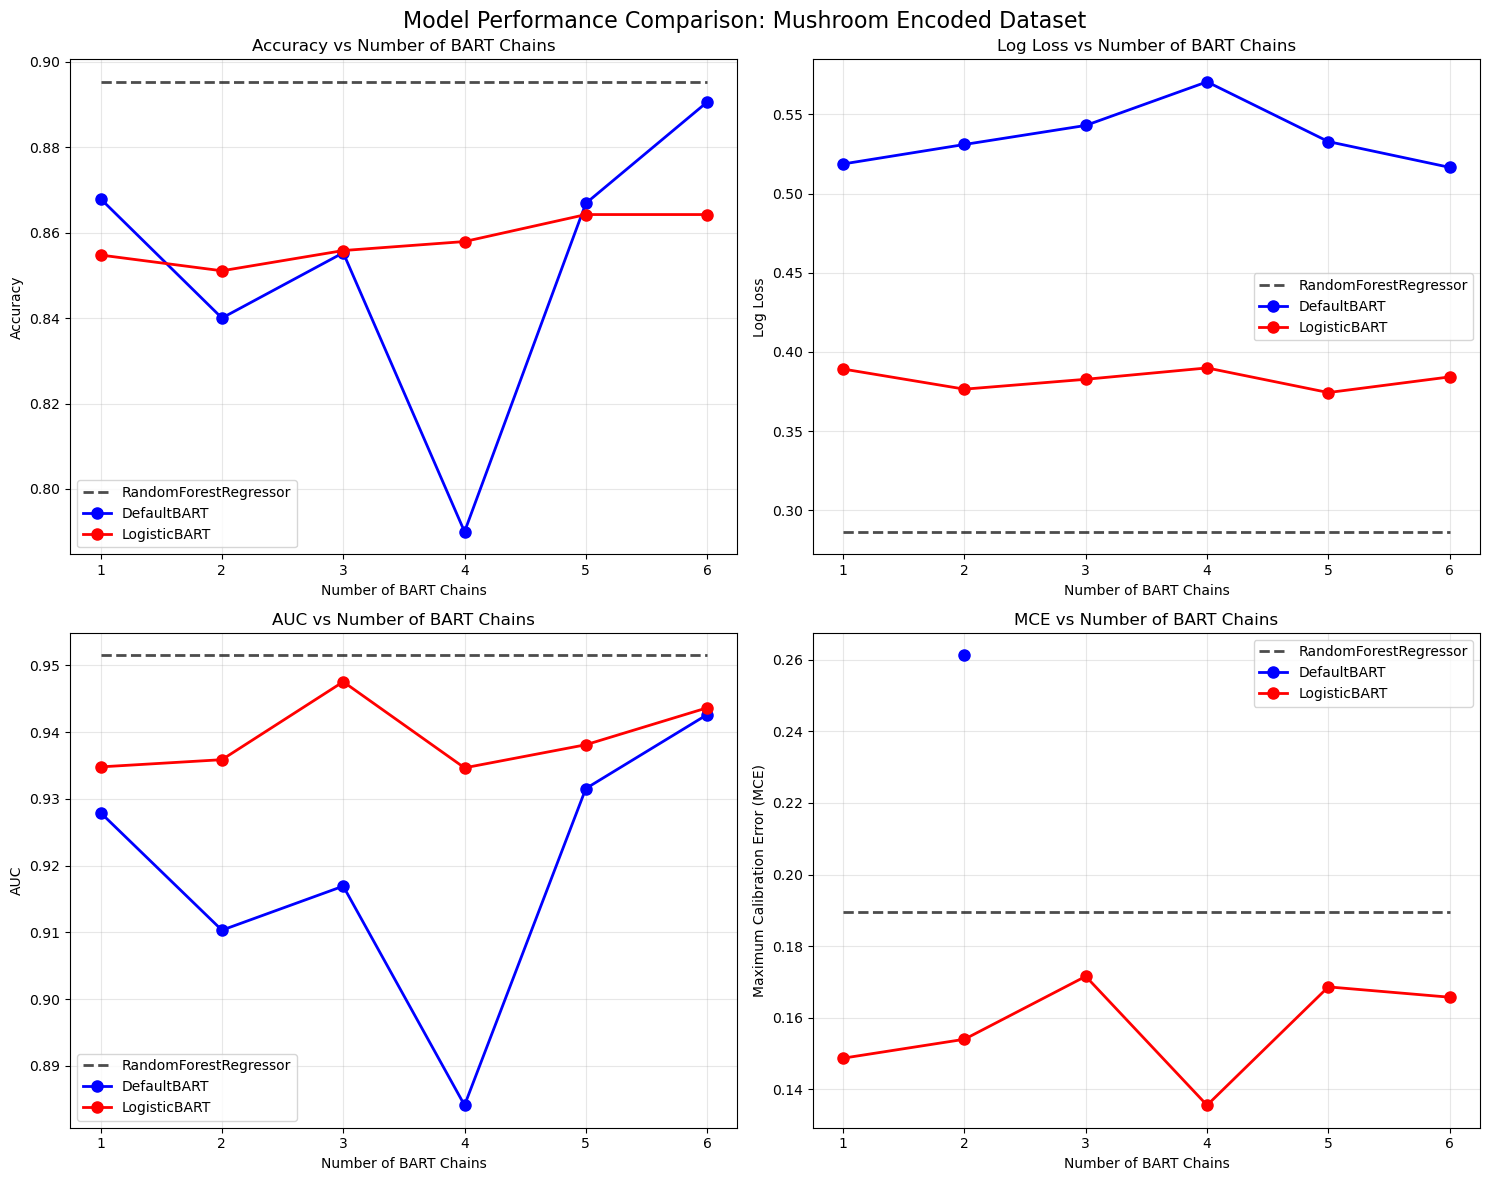

In [12]:
# Create comprehensive plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Model Performance Comparison: Mushroom Encoded Dataset', fontsize=16)

# Separate data by model type
rf_data = results_df[results_df['model'] == 'RandomForestRegressor']
defaultbart_data = results_df[results_df['model'].str.contains('DefaultBART')]
logisticbart_data = results_df[results_df['model'].str.contains('LogisticBART')]

# Plot 1: Accuracy vs bart_num
axes[0, 0].plot(rf_data['bart_num'], rf_data['accuracy'], 'k--', linewidth=2, label='RandomForestRegressor', alpha=0.7)
axes[0, 0].plot(defaultbart_data['bart_num'], defaultbart_data['accuracy'], 'bo-', linewidth=2, markersize=8, label='DefaultBART')
axes[0, 0].plot(logisticbart_data['bart_num'], logisticbart_data['accuracy'], 'ro-', linewidth=2, markersize=8, label='LogisticBART')
axes[0, 0].set_xlabel('Number of BART Chains')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Accuracy vs Number of BART Chains')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(bart_nums)
axes[0, 0].legend()

# Plot 2: LogLoss vs bart_num
axes[0, 1].plot(rf_data['bart_num'], rf_data['log_loss'], 'k--', linewidth=2, label='RandomForestRegressor', alpha=0.7)
axes[0, 1].plot(defaultbart_data['bart_num'], defaultbart_data['log_loss'], 'bo-', linewidth=2, markersize=8, label='DefaultBART')
axes[0, 1].plot(logisticbart_data['bart_num'], logisticbart_data['log_loss'], 'ro-', linewidth=2, markersize=8, label='LogisticBART')
axes[0, 1].set_xlabel('Number of BART Chains')
axes[0, 1].set_ylabel('Log Loss')
axes[0, 1].set_title('Log Loss vs Number of BART Chains')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(bart_nums)
axes[0, 1].legend()

# Plot 3: AUC vs bart_num
axes[1, 0].plot(rf_data['bart_num'], rf_data['auc'], 'k--', linewidth=2, label='RandomForestRegressor', alpha=0.7)
axes[1, 0].plot(defaultbart_data['bart_num'], defaultbart_data['auc'], 'bo-', linewidth=2, markersize=8, label='DefaultBART')
axes[1, 0].plot(logisticbart_data['bart_num'], logisticbart_data['auc'], 'ro-', linewidth=2, markersize=8, label='LogisticBART')
axes[1, 0].set_xlabel('Number of BART Chains')
axes[1, 0].set_ylabel('AUC')
axes[1, 0].set_title('AUC vs Number of BART Chains')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(bart_nums)
axes[1, 0].legend()

# Plot 4: MCE vs bart_num
axes[1, 1].plot(rf_data['bart_num'], rf_data['mce'], 'k--', linewidth=2, label='RandomForestRegressor', alpha=0.7)
axes[1, 1].plot(defaultbart_data['bart_num'], defaultbart_data['mce'], 'bo-', linewidth=2, markersize=8, label='DefaultBART')
axes[1, 1].plot(logisticbart_data['bart_num'], logisticbart_data['mce'], 'ro-', linewidth=2, markersize=8, label='LogisticBART')
axes[1, 1].set_xlabel('Number of BART Chains')
axes[1, 1].set_ylabel('Maximum Calibration Error (MCE)')
axes[1, 1].set_title('MCE vs Number of BART Chains')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xticks(bart_nums)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

In [13]:
# Print summary insights
print("\n" + "="*80)
print("KEY INSIGHTS:")
print("="*80)

# Best performance for each metric
best_accuracy = results_df.loc[results_df['accuracy'].idxmax()]
best_logloss = results_df.loc[results_df['log_loss'].idxmin()]
best_auc = results_df.loc[results_df['auc'].idxmax()]
best_mce = results_df.loc[results_df['mce'].idxmin()]

print(f"Best Accuracy: {best_accuracy['accuracy']:.4f} ({best_accuracy['model']}, bart_num={best_accuracy['bart_num']})")
print(f"Best LogLoss: {best_logloss['log_loss']:.4f} ({best_logloss['model']}, bart_num={best_logloss['bart_num']})")
print(f"Best AUC: {best_auc['auc']:.4f} ({best_auc['model']}, bart_num={best_auc['bart_num']})")
print(f"Best MCE: {best_mce['mce']:.4f} ({best_mce['model']}, bart_num={best_mce['bart_num']})")

print("\nRandomForest Baseline:")
print(f"Accuracy: {rf_metrics['accuracy']:.4f}")
print(f"LogLoss: {rf_metrics['log_loss']:.4f}")
print(f"AUC: {rf_metrics['auc']:.4f}")
print(f"MCE: {rf_metrics['mce']:.4f}")


KEY INSIGHTS:
Best Accuracy: 0.8953 (RandomForestRegressor, bart_num=1)
Best LogLoss: 0.2864 (RandomForestRegressor, bart_num=1)
Best AUC: 0.9515 (RandomForestRegressor, bart_num=1)
Best MCE: 0.1356 (LogisticBART_chains_4, bart_num=4)

RandomForest Baseline:
Accuracy: 0.8953
LogLoss: 0.2864
AUC: 0.9515
MCE: 0.1895
